# DisCoPy: an interfaced software for compositional NLP

DisCoCat and QNLP are all about tensors... but DisCoPy can also handle models based on functions.

1. operad module : CFGs and Dependencies
2. Neural network models
3. biclosed module : Categorial grammar
5. Montague semantics

## 1. Operads, CFGs and dependencies

In [1]:
from discopy.operad import Ob, Box, Tree

x, y = Ob('x'), Ob('y')
f, g, h = Box('f', x, [x, x]), Box('g', x, [x, y]), Box('h', x, [y, x])
composition = Tree(root=f, branches=[g, h])
composition

Tree(f, [Box('g', x, [Ob('x'), Ob('y')]), Box('h', x, [Ob('y'), Ob('x')])])

In [2]:
assert composition == f(g, h)

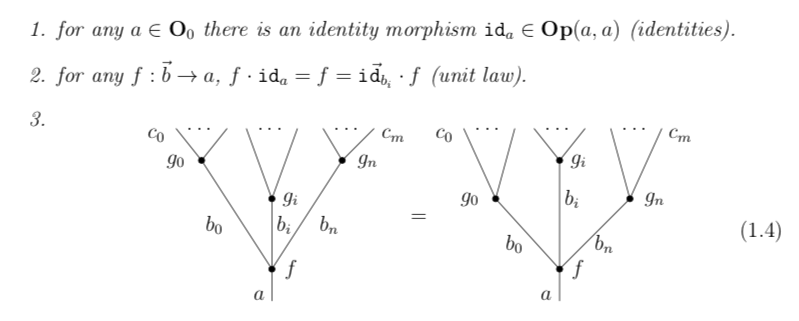

In [3]:
from discopy.operad import Id 

assert Id(x)(f) == f == f(Id(x), Id(x))
left = f(Id(x), h)(g, Id(x), Id(x))
middle = f(g, h)
right = f(g, Id(x))(Id(x), Id(x), h)
assert left == middle == right

### Interface with NLTK for context-free grammar

In [4]:
from nltk import CFG
from nltk.parse import RecursiveDescentParser
grammar = CFG.fromstring("""
S -> VP NP
NP -> D N
VP -> N V
N -> 'Caesar'
V -> 'crossed'
D -> 'the'
N -> 'Rubicon'""")

rd = RecursiveDescentParser(grammar)
parse = next(rd.parse('Caesar crossed the Rubicon'.split()))
print(parse)

(S (VP (N Caesar) (V crossed)) (NP (D the) (N Rubicon)))


In [5]:
from discopy.operad import from_nltk, tree2diagram

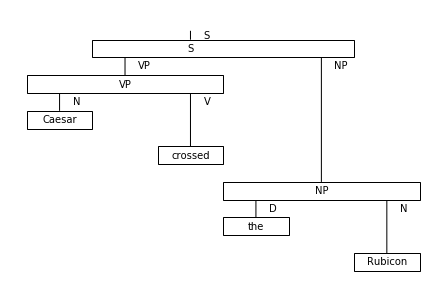

In [6]:
tree2diagram(from_nltk(parse)).draw()

### Interface with Spacy for dependency grammar

In [7]:
import spacy 
nlp = spacy.load("en_core_web_sm") 
doc = nlp("Caesar crossed the Red Sea") 

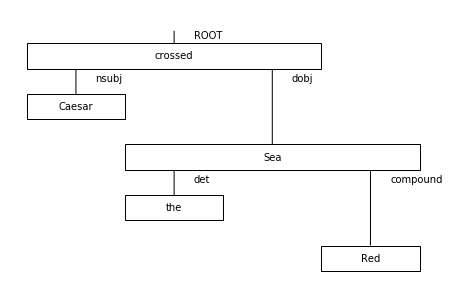

In [8]:
from discopy.operad import from_spacy
tree2diagram(from_spacy(doc)).draw()

## 2. Neural network models

In [9]:
import tensorflow as tf
from tensorflow import keras
from discopy import monoidal


class Network(monoidal.Box):
    def __init__(self, dom, cod, model):
        self.model = model
        super().__init__("Network", dom, cod)

    def then(self, other):
        inputs = keras.Input(shape=(len(self.dom),))
        output = self.model(inputs)
        output = other.model(output)
        composition = keras.Model(inputs=inputs, outputs=output)
        return Network(self.dom, other.cod, composition)

    def tensor(self, other):
        dom = len(self.dom) + len(other.dom)
        cod = len(self.cod) + len(other.cod)
        inputs = keras.Input(shape=(dom,))
        model1 = keras.layers.Lambda(
            lambda x: x[:, :len(self.dom)],)(inputs)
        model2 = keras.layers.Lambda(
            lambda x: x[:, len(self.dom):],)(inputs)
        model1 = self.model(model1)
        model2 = other.model(model2)
        outputs = keras.layers.Concatenate()([model1, model2])
        model = keras.Model(inputs=inputs, outputs=outputs)
        return Network(PRO(dom), PRO(cod), model)

    @staticmethod
    def id(dim):
        inputs = keras.Input(shape=(len(dim),))
        return Network(dim, dim, keras.Model(inputs=inputs, outputs=inputs))

    @staticmethod
    def dense_model(dom, cod, name=None, hidden_layer_dims=[], activation=tf.nn.relu):
        inputs = keras.Input(shape=(dom,))
        model = inputs
        for dim in hidden_layer_dims:
            model = keras.layers.Dense(dim, activation=activation)(model)
        outputs = keras.layers.Dense(cod, activation=activation)(model)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return Network(PRO(dom), PRO(cod), model)

In [10]:
from discopy.monoidal import PRO
from discopy.monoidal import Functor

dim = 5
ob = lambda x: PRO(dim)
ar = lambda box: Network.dense_model(len(box.dom) * dim, len(box.cod) * dim, name=box.name)
F = Functor(ob, ar, ob_factory=PRO, ar_factory=Network)
F(tree2diagram(from_spacy(doc))).model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
model_20 (Functional)        (None, 5)                 120       
_________________________________________________________________
model_24 (Functional)        (None, 0)                 0         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


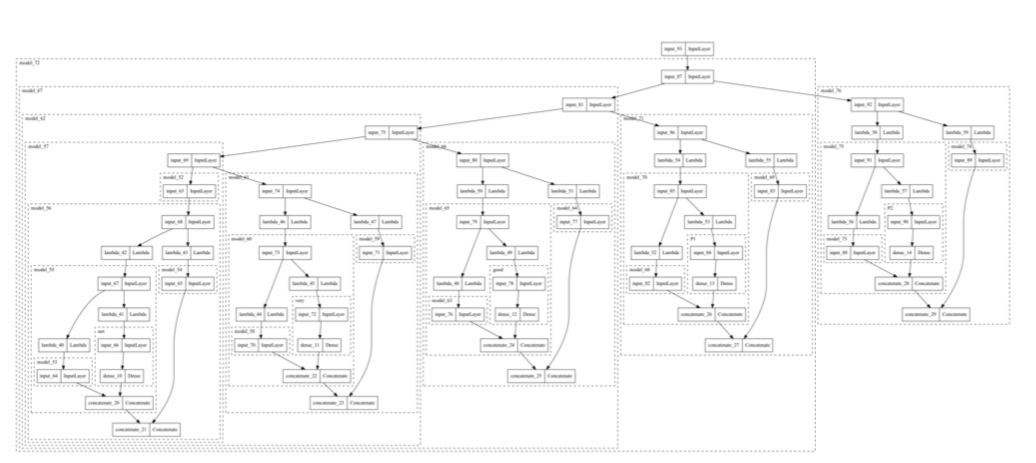

## 3. Biclosed categories and Categorial grammars

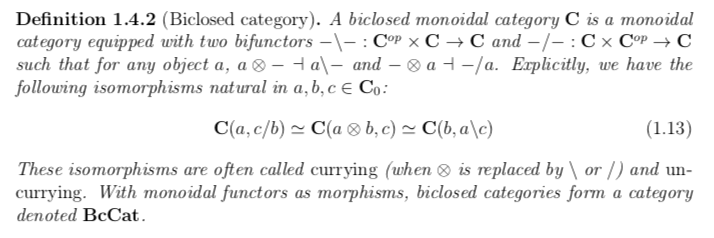

In [11]:
from discopy import monoidal

class Diagram(monoidal.Diagram):
    """ Diagrams in a biclosed monoidal category. """

    def curry(self, n_wires=1, left=False):
        """ Diagram currying. """
        return Curry(self, n_wires, left)

    def uncurry(self):
        """ Diagram uncurrying. """
        return UnCurry(self)

class Box(monoidal.Box, Diagram):
    ...
    
class Id(monoidal.Id, Diagram):
    ...

In [12]:
class Curry(Box):
    """
    Curried diagram.
    """
    def __init__(self, diagram, n_wires=1, left=False):
        name = "Curry({})".format(diagram)
        if left:
            dom = diagram.dom[n_wires:]
            cod = diagram.dom[:n_wires] >> diagram.cod
        else:
            dom = diagram.dom[:-n_wires]
            cod = diagram.cod << diagram.dom[-n_wires or len(diagram.dom):]
        self.diagram, self.n_wires, self.left = diagram, n_wires, left
        super().__init__(name, dom, cod)
        
    def __repr__(self):
        return "Curry({}, n_wires={}, left={})".format(self.diagram, self.n_wires, self.left)


class UnCurry(Box):
    """
    Un-Curried diagram.
    """
    def __init__(self, diagram):
        name = "UnCurry({})".format(diagram)
        self.diagram = diagram
        if isinstance(diagram.cod, Over):
            dom = diagram.dom @ diagram.cod.right
            cod = diagram.dom.left
            super().__init__(name, dom, cod)
        elif isinstance(diagram.cod, Under):
            dom = diagram.dom.left @ diagram.dom
            cod = diagram.dom.right
            super().__init__(name, dom, cod)
        else:
            super().__init__(name, diagram.dom, diagram.cod)
            
    def __repr__(self):
        return "UnCurry({})".format(self.diagram)

In [13]:
from discopy.biclosed import Ty, Over, Under

x, y, z = Ty('x'), Ty('y'), Ty('z')

# Adjiuciewicz

FA = lambda a, b: UnCurry(Id(a >> b))
assert FA(x, y).dom == x @ (x >> y) and FA(x, y).cod == y

BA = lambda a, b: UnCurry(Id(b << a))
assert BA(x, y).dom == (y << x) @ x and BA(x, y).cod == y


# Lambek

proofFC = FA(x, y) @ Id(y >> z) >> FA(y, z)
FC = Curry(proofFC, left=True)
assert FC.dom == (x >> y) @ (y >> z) and FC.cod == (x >> z)

BC = Curry(Id(x << y) @ BA(z, y) >> BA(y, x))
assert BC.dom == (x << y) @ (y << z) and BC.cod == (x << z)

TYR = Curry(UnCurry(Id(x >> y)))
assert TYR.dom == x and TYR.cod == (y << (x >> y))


# Combinatory Categorial grammars

Swap = lambda a, b: Box('Swap', a @ b, b @ a)
proofBX = Id(x << y) @ (Swap(z >> y, z) >> FA(z, y)) >> BA(y, x)
BX = Curry(proofBX)
assert BX.dom == (x << y) @ (z >> y) and BX.cod == (x << z)

proofFX = (Swap(x, y << x) >> BA(x, y)) @ Id(y >> z) >> FA(y, z)
FX = Curry(proofFX, left=True)
assert FX.dom == (y << x) @ (y >> z) and FX.cod == (x >> z)

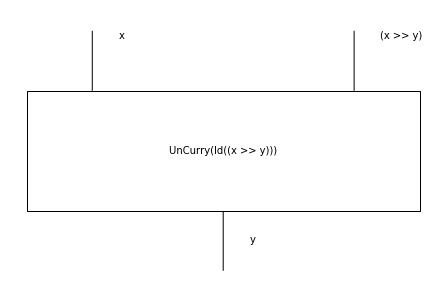

In [14]:
FA(x, y).draw()

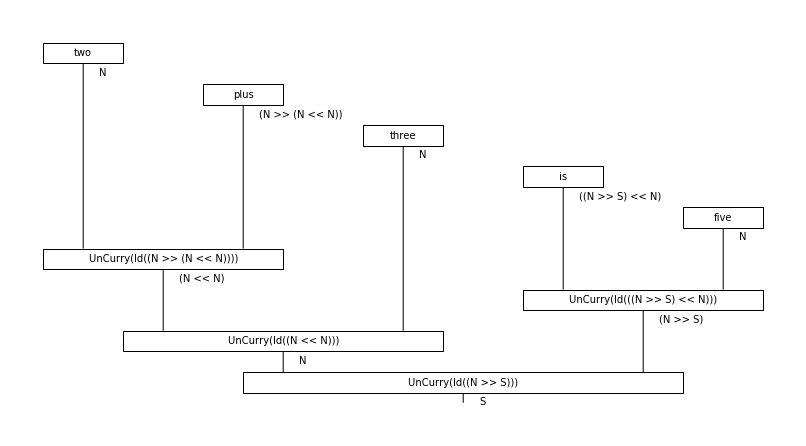

In [15]:
N, S = Ty('N'), Ty('S')
two, three, five = Box('two', Ty(), N), Box('three', Ty(), N), Box('five', Ty(), N)
plus, is_ = Box('plus', Ty(), N >> (N << N)), Box('is', Ty(), N >> S << N)
sentence = two @ plus @ three @ is_ @ five
grammar = FA(N, N << N) @ Id(N) @ BA(N, N >> S) >> BA(N, N) @ Id(N >> S) >> FA(N, S)
sentence = sentence >> grammar
sentence.draw(figsize=(11, 6))

## 4. The category of Functions

In [16]:
class Function(Box):
    def __init__(self, inside, dom, cod):
        self.inside = inside
        name = "Function({}, {}, {})".format(inside, dom, cod)
        super().__init__(name, dom, cod)

    def then(self, other):
        inside = lambda *xs: other(*tuple(self(*xs)))
        return Function(inside, self.dom, other.cod)

    def tensor(self, other):
        def inside(*xs):
            left, right = xs[:len(self.dom)], xs[len(self.dom):]
            result = tuple(self(*left)) + tuple(other(*right))
            return (result[0], ) if len(self.cod @ other.cod) == 1 else result
        return Function(inside, self.dom @ other.dom, self.cod @ other.cod)

    def __call__(self, *xs): return self.inside(*xs)

    @staticmethod
    def id(x):
        return Function(lambda *xs: xs, x, x)

    @staticmethod
    def copy(x):
        return Function(lambda *xs: (*xs, *xs), x, x @ x)
    
    @staticmethod
    def delete(x):
        return Function(lambda *xs: (), x, Ty())
    
    @staticmethod
    def swap(x, y):
        return Function(lambda x0, y0: (y0, x0), x @ y, y @ x)
    
    def curry(self, n_wires=1, left=False):
        if not left:
            dom = self.dom[:-n_wires]
            cod = self.cod << self.dom[-n_wires:]
            inside = lambda *xl: (lambda *xr: self.inside(*(xl + xr)),)
            return Function(inside, dom, cod)
        else:
            dom = self.dom[n_wires:]
            cod = self.dom[:n_wires] >> self.cod
            inside = lambda *xl: (lambda *xr: self.inside(*(xl + xr)),)
            return Function(inside, dom, cod)
        
    def uncurry(self):
        if isinstance(self.cod, Over):
            left, right = self.cod.left, self.cod.right
            cod = left
            dom = self.dom @ right
            inside = lambda *xs: self.inside(*xs[:len(self.dom)])[0](*xs[len(self.dom):])
            return Function(inside, dom, cod)
        elif isinstance(self.cod, Under):
            left, right = self.cod.left, self.cod.right
            cod = right
            dom = left @ self.dom
            inside = lambda *xs: self.inside(*xs[len(left):])[0](*xs[:len(left)])
            return Function(inside, dom, cod)
        return self

We can check the axioms of cartesian categories

In [17]:
X = Ty('X')
copy = Function.copy(X)
delete = Function.delete(X)
I = Function.id(X)
swap = Function.swap(X, X)

assert (copy >> copy @ I)(54) == (copy >> I @ copy)(54)
assert (copy >> delete @ I)(46) == (copy >> I @ delete)(46)
assert (copy >> swap)('was my number') == (copy)('was my number')

f = Function(lambda x: (46,) if x == 54 else (54,), X, X)
assert (f >> copy)(54) == (copy >> f @ f)(54)
assert (copy @ copy >> I @ swap @ I)(54, 46) == Function.copy(X @ X)(54, 46)

## 5. Montague semantics

In [18]:
from discopy import biclosed

class Functor(biclosed.Functor):
    def __init__(self, ob, ar, ob_factory=Ty, ar_factory=Diagram):
        super().__init__(ob, ar, ob_factory, ar_factory)

    def __call__(self, diagram):
        if isinstance(diagram, Curry):
            n_wires = len(self(getattr(
                diagram.cod, 'left' if diagram.left else 'right')))
            return self.ar_factory.curry(
                self(diagram.diagram), n_wires, diagram.left)
        if isinstance(diagram, UnCurry):
            return self.ar_factory.uncurry(self(diagram.diagram))
        return super().__call__(diagram)

In [19]:
number = lambda y: Function(lambda: (y, ), Ty(), N)
add = Function(lambda x, y: (x + y,), N @ N, N)
is_equal = Function(lambda x, y: (x == y, ), N @ N, S)

ob = lambda x: x
ar = {two: number(2), three: number(3), five: number(5),
      is_: is_equal.curry().curry(left=True), 
      plus: add.curry().curry(left=True)}
F = Functor(ob, ar, ob_factory=Ty, ar_factory=Function)
F(sentence)()

(True,)

## Summary

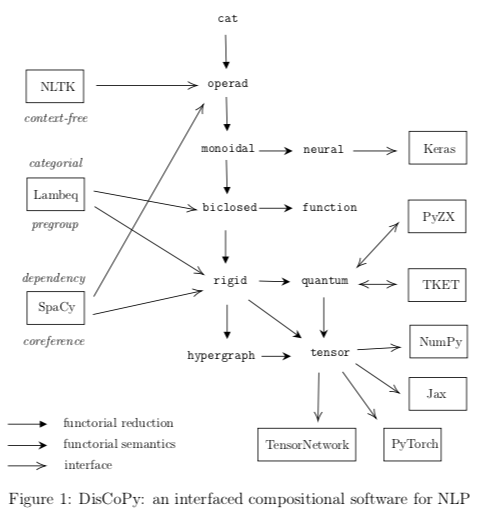